# Import Libraries and Setup

In [1]:
# Import Libraries and Setup
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
import pandas as pd
from collections import OrderedDict
import warnings
from scipy.stats import kurtosis, skew, ttest_ind
import os

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Verify GPU availability
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"TensorFlow GPU devices: {len(tf.config.experimental.list_physical_devices('GPU'))}")

2025-08-02 06:18:19.171149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754115499.468868      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754115499.548044      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


PyTorch CUDA available: True
TensorFlow GPU devices: 2


# U-Net Architecture

In [2]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [3]:
# UNet class (same as provided)
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)
        self.apply(init_weights)  # Initialize weights

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))
        b = self.bottleneck(F.max_pool2d(e4, 2))
        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)

# TensorFlow model (same as provided)
def create_tf_model(input_shape=(256, 256, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    def conv_block(x, filters, name_prefix):
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', name=f'{name_prefix}_conv1')(x)
        x = tf.keras.layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
        x = tf.keras.layers.ReLU(name=f'{name_prefix}_relu1')(x)
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', name=f'{name_prefix}_conv2')(x)
        x = tf.keras.layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)
        x = tf.keras.layers.ReLU(name=f'{name_prefix}_relu2')(x)
        return x
    e1 = conv_block(inputs, 64, 'enc1')
    e2 = conv_block(tf.keras.layers.MaxPooling2D(2)(e1), 128, 'enc2')
    e3 = conv_block(tf.keras.layers.MaxPooling2D(2)(e2), 256, 'enc3')
    e4 = conv_block(tf.keras.layers.MaxPooling2D(2)(e3), 512, 'enc4')
    b = conv_block(tf.keras.layers.MaxPooling2D(2)(e4), 1024, 'bottleneck')
    d4 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same', name='up4')(b)
    d4 = tf.keras.layers.Concatenate(name='concat4')([d4, e4])
    d4 = conv_block(d4, 512, 'dec4')
    d3 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same', name='up3')(d4)
    d3 = tf.keras.layers.Concatenate(name='concat3')([d3, e3])
    d3 = conv_block(d3, 256, 'dec3')
    d2 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same', name='up2')(d3)
    d2 = tf.keras.layers.Concatenate(name='concat2')([d2, e2])
    d2 = conv_block(d2, 128, 'dec2')
    d1 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same', name='up1')(d2)
    d1 = tf.keras.layers.Concatenate(name='concat1')([d1, e1])
    d1 = conv_block(d1, 64, 'dec1')
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name='final')(d1)
    return tf.keras.Model(inputs, outputs, name='unet')

# Test model instantiation
pytorch_model = UNet(in_channels=1, out_channels=1)
print(f"PyTorch model parameters: {sum(p.numel() for p in pytorch_model.parameters()):,}")

PyTorch model parameters: 31,042,369


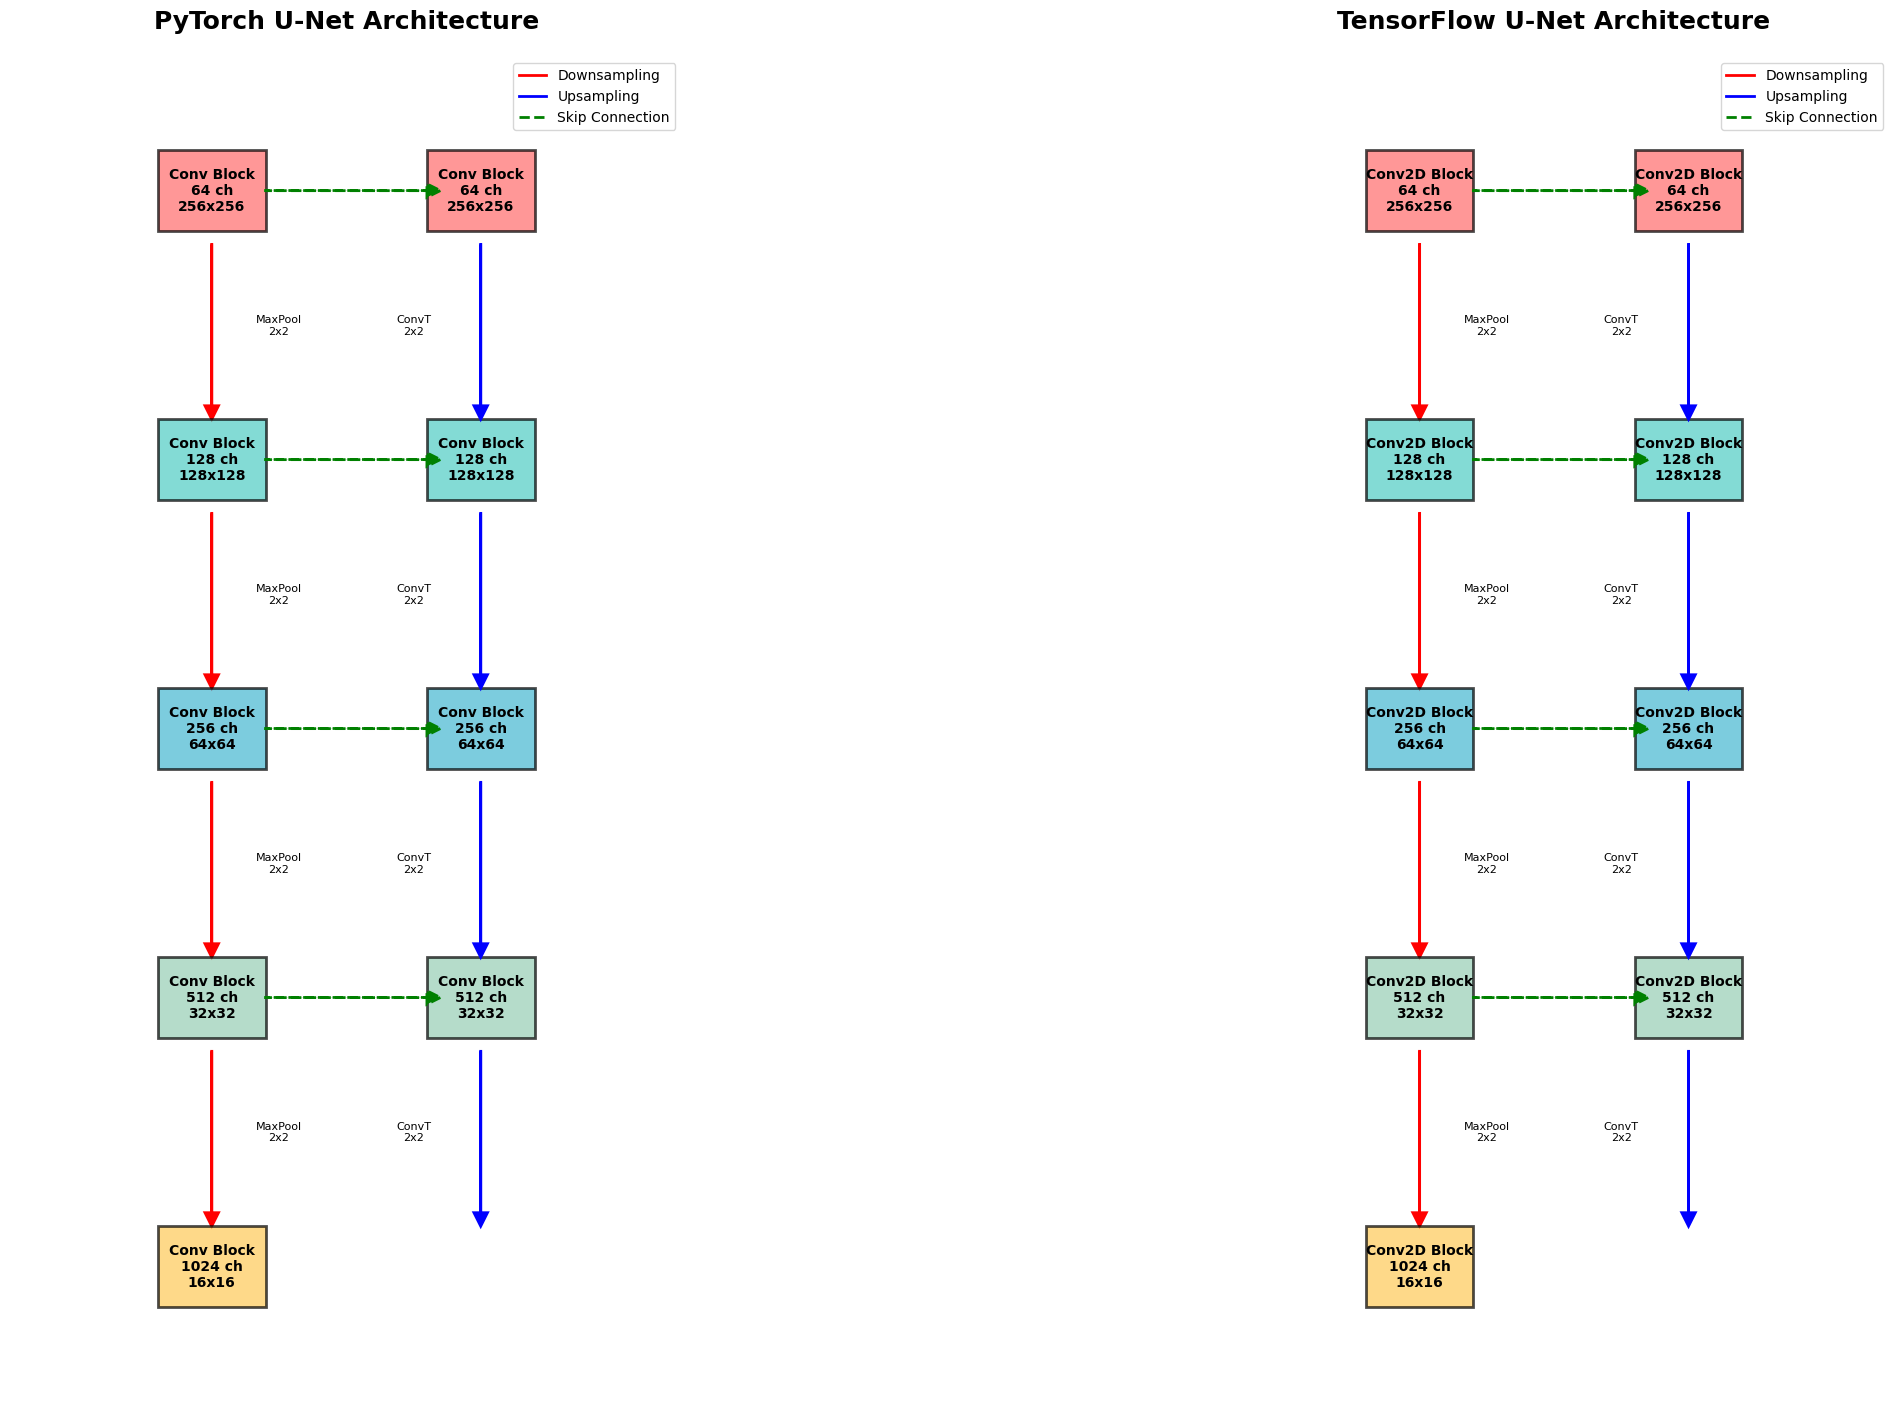

In [4]:
def visualize_model_architecture():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 14), constrained_layout=True)
    
    # Common setup
    encoder_x = [1, 1, 1, 1, 1]
    encoder_y = [8, 6, 4, 2, 0]
    decoder_x = [3, 3, 3, 3, 3]
    decoder_y = [0, 2, 4, 6, 8]
    channels = [64, 128, 256, 512, 1024]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
    feature_sizes = [(256, 256), (128, 128), (64, 64), (32, 32), (16, 16)]
    
    def draw_blocks(ax, title, block_label):
        ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
        for i, (x, y, ch, color, size) in enumerate(zip(encoder_x, encoder_y, channels, colors, feature_sizes)):
            rect = plt.Rectangle((x-0.4, y-0.3), 0.8, 0.6, facecolor=color, alpha=0.7, edgecolor='black', linewidth=2)
            ax.add_patch(rect)
            ax.text(x, y, f'{block_label}\n{ch} ch\n{size[0]}x{size[1]}', ha='center', va='center', fontweight='bold', fontsize=10)
            if i < 4:
                ax.arrow(x, y-0.4, 0, -1.2, head_width=0.1, head_length=0.1, fc='red', ec='red', linewidth=2)
                ax.text(x+0.5, y-1, 'MaxPool\n2x2', ha='center', va='center', fontsize=8)
        for i, (x, y, ch, color, size) in enumerate(zip(decoder_x, decoder_y, channels[::-1], colors[::-1], feature_sizes[::-1])):
            if i > 0:
                rect = plt.Rectangle((x-0.4, y-0.3), 0.8, 0.6, facecolor=color, alpha=0.7, edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y, f'{block_label}\n{ch} ch\n{size[0]}x{size[1]}', ha='center', va='center', fontweight='bold', fontsize=10)
                ax.arrow(x, y-0.4, 0, -1.2, head_width=0.1, head_length=0.1, fc='blue', ec='blue', linewidth=2)
                ax.text(x-0.5, y-1, 'ConvT\n2x2', ha='center', va='center', fontsize=8)
                ax.arrow(encoder_x[4-i]+0.4, encoder_y[4-i], 1.2, 0, head_width=0.1, head_length=0.1, fc='green', ec='green', linewidth=2, linestyle='--')
        ax.set_xlim(-0.5, 4.5)
        ax.set_ylim(-1, 9)
        ax.set_aspect('equal')
        ax.axis('off')
        legend_elements = [
            plt.Line2D([0], [0], color='red', lw=2, label='Downsampling'),
            plt.Line2D([0], [0], color='blue', lw=2, label='Upsampling'),
            plt.Line2D([0], [0], color='green', lw=2, linestyle='--', label='Skip Connection')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    draw_blocks(ax1, 'PyTorch U-Net Architecture', 'Conv Block')
    draw_blocks(ax2, 'TensorFlow U-Net Architecture', 'Conv2D Block')
    plt.savefig('model_architecture_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Execute visualization
visualize_model_architecture()

In [6]:
def create_conversion_summary_table(pytorch_model, tf_model):
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.axis('tight')
    ax.axis('off')
    
    pytorch_info = []
    for name, module in pytorch_model.named_modules():
        if len(list(module.children())) == 0:
            params = sum(p.numel() for p in module.parameters())
            if params > 0:
                pytorch_info.append([name, module.__class__.__name__, str(params)])
    
    tf_info = []
    for layer in tf_model.layers:
        if hasattr(layer, 'weights') and layer.weights:
            params = layer.count_params()
            tf_info.append([layer.name, layer.__class__.__name__, str(params)])
    
    max_rows = max(len(pytorch_info), len(tf_info))
    table_data = []
    for i in range(max_rows):
        row = []
        p_params = int(pytorch_info[i][2]) if i < len(pytorch_info) else 0
        tf_params = int(tf_info[i][2]) if i < len(tf_info) else 0
        row.extend(pytorch_info[i] if i < len(pytorch_info) else ['', '', ''])
        row.append('⟷')
        row.extend(tf_info[i] if i < len(tf_info) else ['', '', ''])
        row.append(str(abs(p_params - tf_params)))
        table_data.append(row)
    
    headers = ['PyTorch Layer', 'Type', 'Parameters', '→', 'TensorFlow Layer', 'Type', 'Parameters', 'Param Diff']
    table = ax.table(cellText=table_data[:15], colLabels=headers, cellLoc='center', loc='center', colWidths=[0.2, 0.15, 0.1, 0.05, 0.2, 0.15, 0.1, 0.1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_facecolor('#4ECDC4')
            cell.set_text_props(weight='bold', color='white')
        elif j == 3:
            cell.set_facecolor('#F0F0F0')
        elif j == 7:  # Parameter difference column
            diff = int(cell.get_text().get_text()) if cell.get_text().get_text() else 0
            cell.set_facecolor('#FF6B6B' if diff > 0 else '#FFFFFF')
        else:
            cell.set_facecolor('#FFFFFF' if i % 2 == 0 else '#F8F8F8')
    
    ax.set_title('Layer-by-Layer Conversion Mapping', fontsize=16, fontweight='bold', pad=20)
    plt.savefig('conversion_summary_table.png', dpi=300, bbox_inches='tight')
    plt.show()

tf_model = create_tf_model()
print(f"TensorFlow model parameters: {tf_model.count_params():,}")
tf_model.summary()

TensorFlow model parameters: 31,054,145


Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_conv1 (Conv2D)       │ (None, 256, 256, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_bn1                  │ (None, 256, 256, 64)   │            256 │ enc1_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_relu1 (ReLU)         │ (None, 256, 256, 64)   │              0 │ enc1_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_conv2 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ enc1_relu1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_bn2                  │ (None, 256, 256, 64)   │            256 │ enc1_conv2[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_relu2 (ReLU)         │ (None, 256, 256, 64)   │              0 │ enc1_bn2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ enc1_relu2[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_conv1 (Conv2D)       │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_bn1                  │ (None, 128, 128, 128)  │            512 │ enc2_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_relu1 (ReLU)         │ (None, 128, 128, 128)  │              0 │ enc2_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_conv2 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ enc2_relu1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_bn2                  │ (None, 128, 128, 128)  │            512 │ enc2_conv2[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_relu2 (ReLU)         │ (None, 128, 128, 128)  │              0 │ enc2_bn2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ enc2_relu2[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc3_conv1 (Conv2D)       │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├──────────────────────

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [7]:
!pip install nibabel

In [8]:
import nibabel as nib

image_path = "/kaggle/input/mri-dataset-for-detection-and-analysis/3D_volumetric_imaging/Walnut_CT_complete/walnut.nii"
image_nifti = nib.load(image_path)
image_volume = image_nifti.get_fdata()

print(image_volume.shape)
print(image_volume.dtype)
print(image_volume)

(400, 296, 352)
float64
[[[329. 288. 389. ... 402. 374. 334.]
  [433. 369. 261. ... 297. 215. 100.]
  [110. 121.  13. ... 155.   0.  23.]
  ...
  [218.  79. 109. ... 325. 291. 409.]
  [156. 154. 178. ... 313. 344. 263.]
  [ 22. 183. 327. ... 222. 330. 225.]]

 [[321. 273. 164. ... 178. 275. 298.]
  [380. 278. 130. ... 410. 317. 204.]
  [103. 102.   7. ... 190.   0.   3.]
  ...
  [403. 345. 295. ... 499. 360. 296.]
  [189. 333. 540. ... 201. 249. 280.]
  [ 46. 340. 625. ...  94. 184. 281.]]

 [[437. 387. 304. ... 155. 219. 311.]
  [470. 381. 332. ... 127. 167. 261.]
  [ 61.  21.   0. ...  94.  70. 208.]
  ...
  [397. 502. 497. ... 362. 406. 356.]
  [297. 421. 448. ... 192. 274. 395.]
  [471. 343. 270. ... 119. 112. 286.]]

 ...

 [[ 99.  50.  31. ... 505. 466. 419.]
  [173. 215. 214. ... 186. 252. 247.]
  [396. 423. 457. ... 169. 270. 398.]
  ...
  [192. 112.  40. ...   1.   0.  58.]
  [130. 188. 196. ...  80. 156. 178.]
  [ 92. 257. 286. ... 257. 314. 295.]]

 [[ 55. 136.  91. ... 302.

In [9]:
import nibabel as nib

mask_path = "/kaggle/input/mri-dataset-for-detection-and-analysis/3D_volumetric_imaging/Walnut_CT_masked/walnut_masked.nii"
mask_nifti = nib.load(mask_path)
mask_volume = mask_nifti.get_fdata()

print(mask_volume.shape)
print(mask_volume.dtype)
print(mask_volume)

(400, 296, 352, 1)
float64
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0

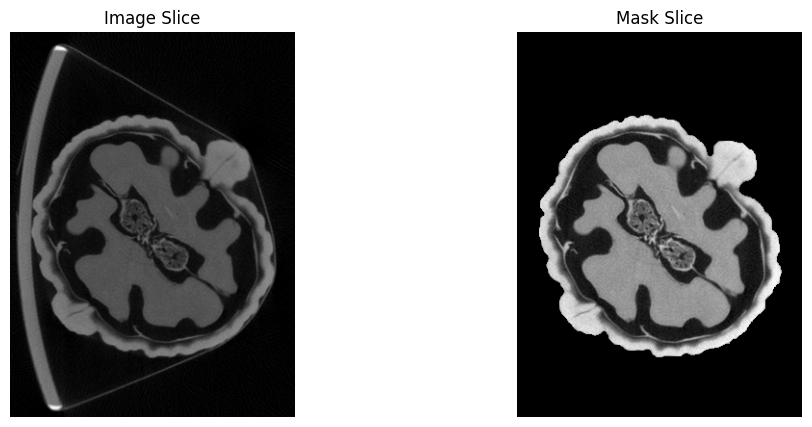

In [10]:
import matplotlib.pyplot as plt

slice_idx = image_volume.shape[2] // 2

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_volume[:, :, slice_idx], cmap='gray')
plt.title("Image Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_volume[:, :, slice_idx], cmap='gray')
plt.title("Mask Slice")
plt.axis("off")

plt.show()

# Data Preprocessing and Training

In [11]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2

# Normalize and resize each 2D slice
image_slices = []
mask_slices = []

for i in range(image_volume.shape[2]):
    img_slice = image_volume[:, :, i]
    mask_slice = mask_volume[:, :, i]

    # Normalize to 0-1 range and resize
    img = cv2.resize(img_slice, (256, 256)) / 255.0
    mask = cv2.resize(mask_slice, (256, 256)) / 255.0

    image_slices.append(img)
    mask_slices.append(mask)

# Convert to numpy arrays
image_slices = np.array(image_slices)
mask_slices = np.array(mask_slices)

# Train/Val split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_slices, mask_slices, test_size=0.2, random_state=42
)

# PyTorch Dataset
class MRIDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(mask, axis=0)
        return torch.FloatTensor(img), torch.FloatTensor(mask)

# Albumentations transformations
transform = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])

# Create datasets and loaders
train_dataset = MRIDataset(train_imgs, train_masks, transform=transform)
val_dataset = MRIDataset(val_imgs, val_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))

Train set size: 281
Validation set size: 71


In [12]:
# Print shape of one item
sample_img, sample_mask = train_dataset[0]
print("Image shape:", sample_img.shape)
print("Mask shape:", sample_mask.shape)

Image shape: torch.Size([1, 256, 256])
Mask shape: torch.Size([1, 256, 256])


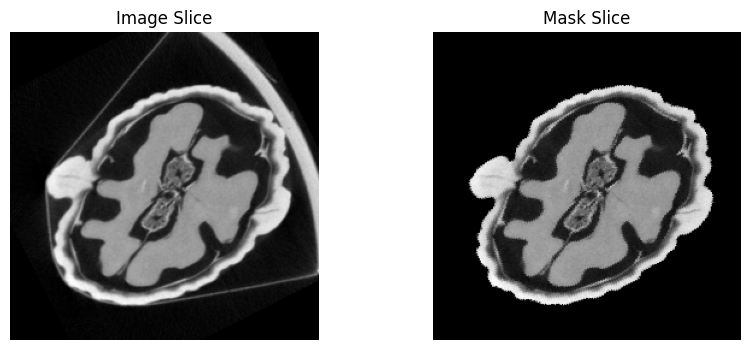

In [13]:
import matplotlib.pyplot as plt

# Get a sample
img_tensor, mask_tensor = train_dataset[0]

# Convert to numpy for plotting
img = img_tensor.squeeze().numpy()
mask = mask_tensor.squeeze().numpy()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Image Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask Slice")
plt.axis("off")

plt.show()

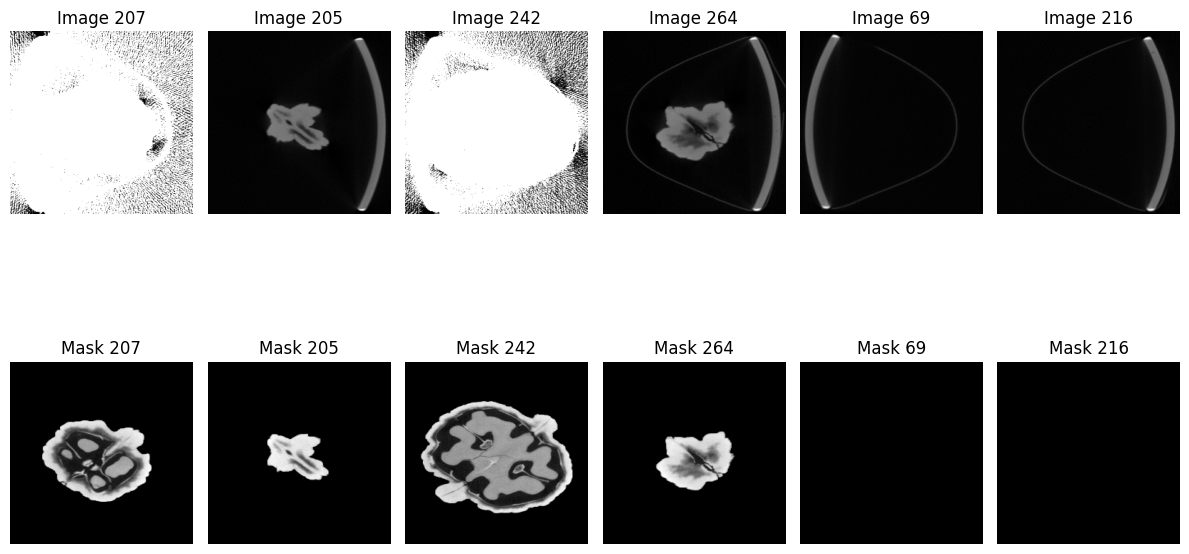

In [14]:
import random

plt.figure(figsize=(12, 8))
for i in range(6):
    idx = random.randint(0, len(train_dataset) - 1)
    img, mask = train_dataset[idx]
    img = img.squeeze().numpy()
    mask = mask.squeeze().numpy()

    plt.subplot(2, 6, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image {idx}")
    plt.axis("off")

    plt.subplot(2, 6, i + 7)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Train the Model with Gradient Monitoring

Epoch 1/10: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s]


Epoch 1/10 | Train Loss: -339.7977 | Val Loss: -738.2602 | Grad Norm: 137.5182


Epoch 2/10: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s]


Epoch 2/10 | Train Loss: -421.8863 | Val Loss: -27.5663 | Grad Norm: 487.5347


Epoch 3/10: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]


Epoch 3/10 | Train Loss: -481.1306 | Val Loss: -671.6663 | Grad Norm: 346.6297


Epoch 4/10: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s]


Epoch 4/10 | Train Loss: -514.8998 | Val Loss: -679.9160 | Grad Norm: 166.8549


Epoch 5/10: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]


Epoch 5/10 | Train Loss: -551.0541 | Val Loss: -905.0114 | Grad Norm: 248.4407


Epoch 6/10: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]


Epoch 6/10 | Train Loss: -597.4141 | Val Loss: -1850.3015 | Grad Norm: 709.3331


Epoch 7/10: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s]


Epoch 7/10 | Train Loss: -628.6280 | Val Loss: -946.9574 | Grad Norm: 1371.2997


Epoch 8/10: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]


Epoch 8/10 | Train Loss: -651.3847 | Val Loss: -1095.1858 | Grad Norm: 33.6583


Epoch 9/10: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s]


Epoch 9/10 | Train Loss: -697.2201 | Val Loss: -433.9320 | Grad Norm: 254.9260


Epoch 10/10: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s]


Epoch 10/10 | Train Loss: -733.7806 | Val Loss: -827.5497 | Grad Norm: 178.2233


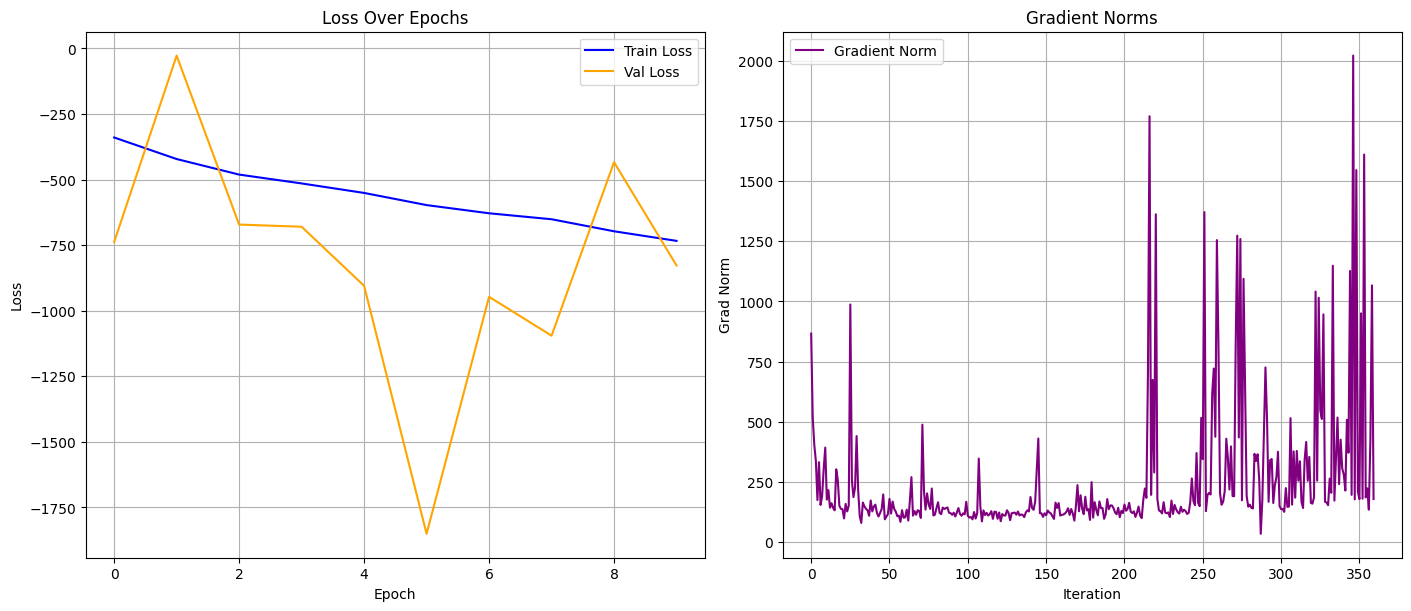

      Metric      Mean       Std
0       Dice  0.504410  0.306063
1        IoU  0.390827  0.263621
2   Accuracy  0.605559  0.232473
3  Precision  0.418836  0.286987
4     Recall  0.826178  0.281425
5         F1  0.504410  0.306063


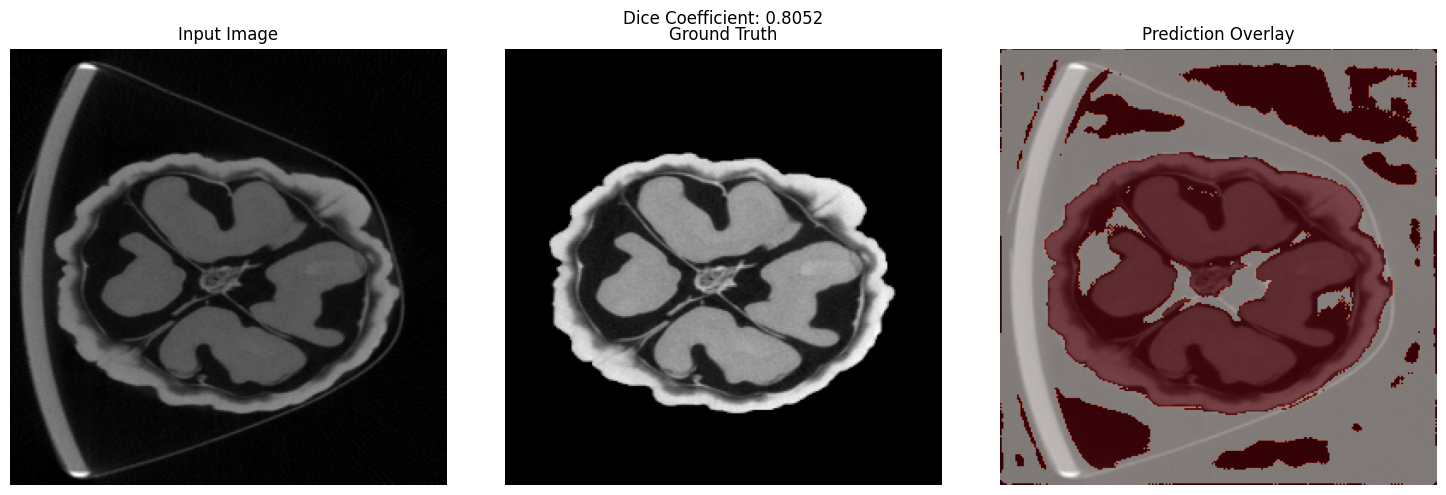

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from scipy.stats import ttest_ind

# Dummy placeholder for your UNet model
# from your_model_file import UNet
# Ensure you have a correct UNet model defined

# --------------------
# Training Function
# --------------------
def train_model(model, train_loader, val_loader, epochs=10, device='cuda'):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses, val_losses, grad_norms = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            grad_norms.append(grad_norm.item())
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Grad Norm: {grad_norm:.4f}")

    # Plot Loss & Grad Norm
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='orange')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(grad_norms, color='purple', label='Gradient Norm')
    ax2.set_title('Gradient Norms')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Grad Norm')
    ax2.legend()
    ax2.grid(True)

    plt.savefig("training_metrics.png", dpi=300)
    plt.show()

    return train_losses, val_losses, grad_norms

# --------------------
# Dice Coefficient
# --------------------
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_true_f = (y_true > threshold).astype(np.uint8).flatten()
    y_pred_f = (y_pred > threshold).astype(np.uint8).flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-6)

# --------------------
# Evaluation Function
# --------------------
def evaluate_model(model, loader, device='cuda'):
    model.eval()
    dice_scores, iou_scores, accs, precs, recs, f1s = [], [], [], [], [], []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images)).cpu().numpy()
            masks = masks.cpu().numpy()

            for i in range(len(outputs)):
                pred = outputs[i, 0] > 0.5
                truth = masks[i, 0] > 0.5

                dice_scores.append(dice_coefficient(truth, pred))
                iou_scores.append(jaccard_score(truth.flatten(), pred.flatten()))
                accs.append(accuracy_score(truth.flatten(), pred.flatten()))
                precs.append(precision_score(truth.flatten(), pred.flatten(), zero_division=0))
                recs.append(recall_score(truth.flatten(), pred.flatten(), zero_division=0))
                f1s.append(f1_score(truth.flatten(), pred.flatten(), zero_division=0))

    return {
        "Dice": np.mean(dice_scores), "Dice_std": np.std(dice_scores),
        "IoU": np.mean(iou_scores), "IoU_std": np.std(iou_scores),
        "Accuracy": np.mean(accs), "Accuracy_std": np.std(accs),
        "Precision": np.mean(precs), "Precision_std": np.std(precs),
        "Recall": np.mean(recs), "Recall_std": np.std(recs),
        "F1": np.mean(f1s), "F1_std": np.std(f1s),
        "All": {
            "Dice": dice_scores, "IoU": iou_scores, "Accuracy": accs,
            "Precision": precs, "Recall": recs, "F1": f1s
        }
    }

# --------------------
# Visualize Prediction Overlay
# --------------------
def visualize_prediction(model, dataset, device='cuda', idx=0):
    model.eval()
    img, mask = dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor)).squeeze().cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img.squeeze(), cmap='gray')
    axes[0].set_title('Input Image')

    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth')

    axes[2].imshow(img.squeeze(), cmap='gray')
    axes[2].imshow(pred > 0.5, alpha=0.5, cmap='Reds')
    axes[2].set_title('Prediction Overlay')

    for ax in axes:
        ax.axis('off')

    dice = dice_coefficient(mask.squeeze().numpy(), pred)
    plt.suptitle(f'Dice Coefficient: {dice:.4f}')
    plt.tight_layout()
    plt.show()

# --------------------
# Run Training + Evaluation
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pytorch_model = UNet(in_channels=1, out_channels=1)  # Replace with actual model
train_losses, val_losses, grad_norms = train_model(pytorch_model, train_loader, val_loader, epochs=10, device=device)

# Evaluate
metrics = evaluate_model(pytorch_model, val_loader, device=device)

# Print results
metrics_df = pd.DataFrame({
    'Metric': ['Dice', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1'],
    'Mean': [metrics[k] for k in ['Dice', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1']],
    'Std': [metrics[f"{k}_std"] for k in ['Dice', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1']]
})
print(metrics_df)

# Save metrics
metrics_df.to_csv("evaluation_metrics.csv", index=False)

# Visualize a prediction
visualize_prediction(pytorch_model, val_dataset, device=device, idx=0)

In [16]:
print("Final Training Loss:", train_losses[-1])
print("Final Validation Loss:", val_losses[-1])
print("Max Gradient Norm:", max(grad_norms))
print("Min Gradient Norm:", min(grad_norms))

Final Training Loss: -733.7805735089177
Final Validation Loss: -827.5497135645907
Max Gradient Norm: 2022.4193115234375
Min Gradient Norm: 33.65827941894531


In [17]:
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

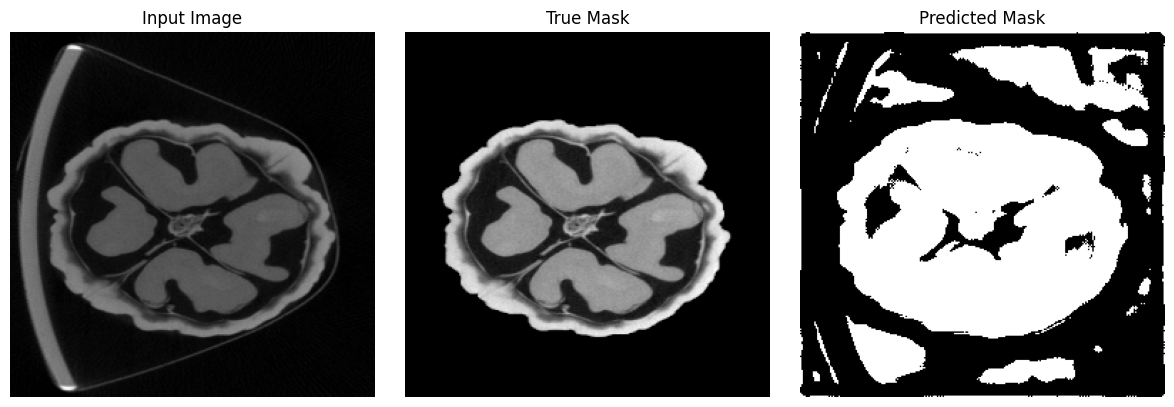

In [18]:
# Sample inference and plot
pytorch_model.eval()
with torch.no_grad():
    img, true_mask = val_dataset[0]
    img = img.unsqueeze(0).to(device)
    pred_mask = torch.sigmoid(pytorch_model(img)).squeeze().cpu().numpy()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze().numpy(), cmap='gray')
plt.title("True Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask > 0.5, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# Numerical Stability Analysis

In [ ]:
# --------------------
# Numerical Stability Analysis
# --------------------
def analyze_numerical_stability(model, grad_norms):
    weights = np.concatenate([
        param.detach().cpu().numpy().flatten()
        for name, param in model.named_parameters()
        if 'weight' in name and param.requires_grad
    ])

    stats = {
        'Weight Mean': np.mean(weights),
        'Weight Std': np.std(weights),
        'Weight Kurtosis': kurtosis(weights),
        'Weight Skewness': skew(weights),
        'Grad Norm Mean': np.mean(grad_norms) if grad_norms else float('nan'),
        'Grad Norm Std': np.std(grad_norms) if grad_norms else float('nan')
    }

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    sns.histplot(weights, bins=100, ax=ax1, color='#FF6B6B', alpha=0.7)
    ax1.set_title('Weight Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Weight Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)

    sns.histplot(grad_norms, bins=50, ax=ax2, color='#4ECDC4', alpha=0.7)
    ax2.set_title('Gradient Norm Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Gradient Norm')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)

    plt.savefig('numerical_stability.png', dpi=300)
    plt.show()

    return stats

# Analyze numerical stability
numerical_stats = analyze_numerical_stability(pytorch_model, grad_norms)
print("\n🔍 Numerical Stability Stats:")
for k, v in numerical_stats.items():
    print(f"{k}: {v:.4f}")

In [ ]:
def visualize_prediction(model, dataset, device='cuda', idx=0):
    model.eval()
    img, true_mask = dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred_mask = torch.sigmoid(model(img_tensor)).squeeze().cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    
    axes[1].imshow(true_mask.squeeze().numpy(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    
    axes[2].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axes[2].imshow(pred_mask > 0.5, alpha=0.4, cmap='Reds')
    axes[2].set_title('Predicted Mask Overlay')
    
    for ax in axes:
        ax.axis('off')
    
    dice = dice_coefficient(true_mask.squeeze().numpy(), pred_mask)
    plt.suptitle(f'Dice Coefficient: {dice:.4f}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage
visualize_prediction(pytorch_model, val_dataset, device=device, idx=0)

# Segmentation Visualization

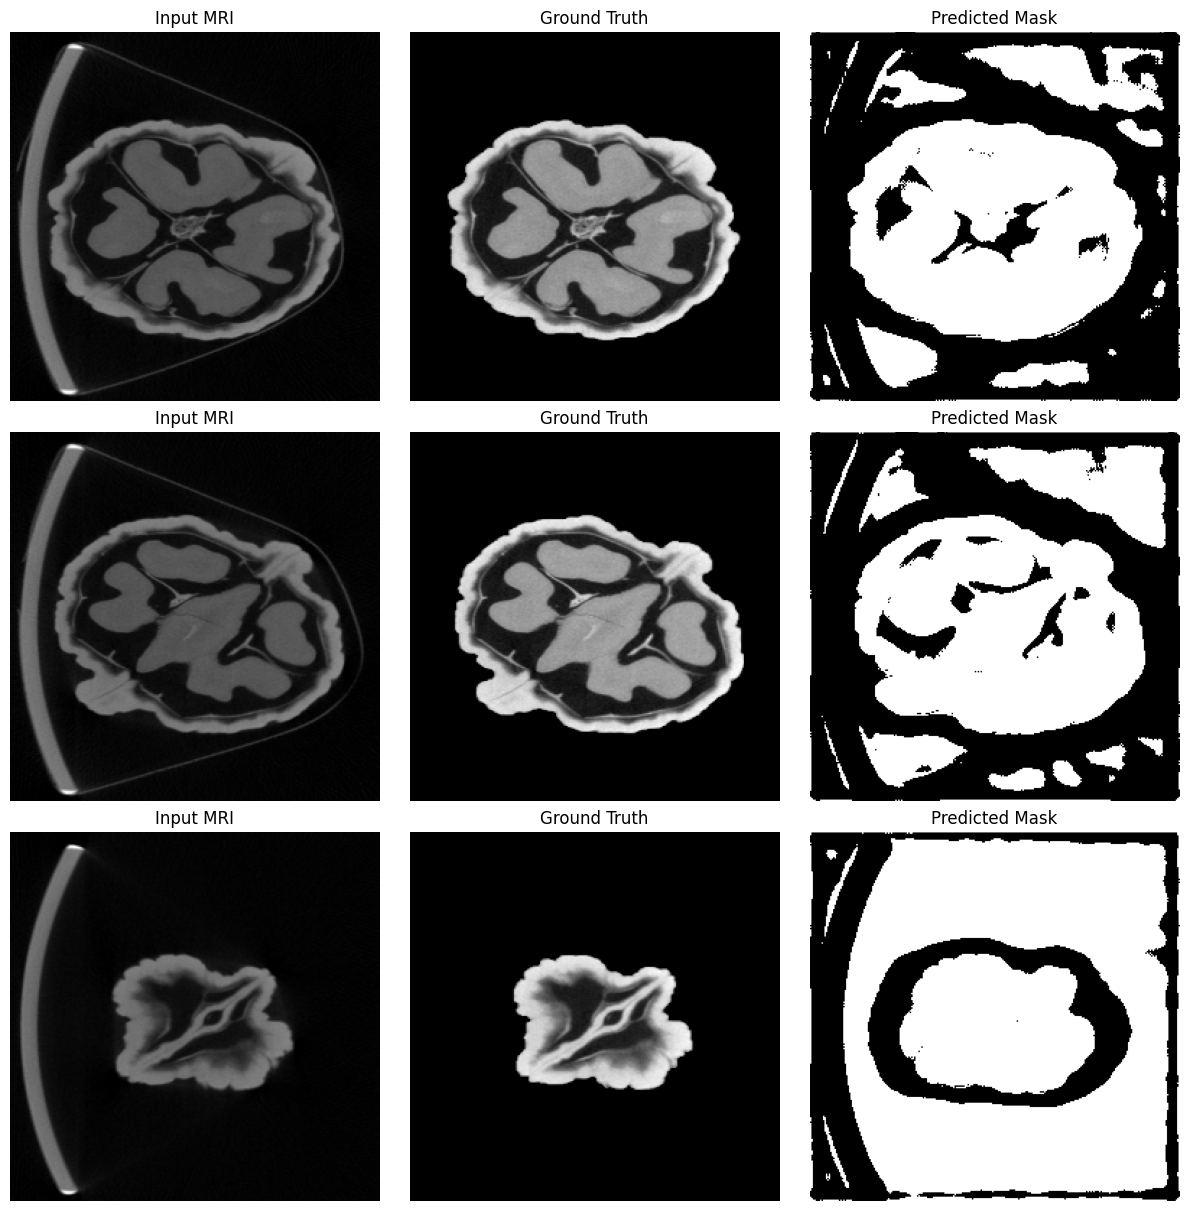

In [19]:
def visualize_segmentation(model, loader, device='cuda', num_samples=3):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples), constrained_layout=True)

    # Ensure axes is 2D (even if num_samples == 1)
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    with torch.no_grad():
        for images, masks in loader:
            batch_size = images.size(0)
            for i in range(batch_size):
                if images_shown >= num_samples:
                    break

                image = images[i].to(device)
                mask = masks[i].to(device)
                output = torch.sigmoid(model(image.unsqueeze(0))).squeeze().cpu().numpy()

                img = image[0].cpu().numpy()
                true_mask = mask[0].cpu().numpy()
                pred_mask = output > 0.5

                row = axes[images_shown]
                row[0].imshow(img, cmap='gray')
                row[0].set_title('Input MRI', fontsize=12)
                row[1].imshow(true_mask, cmap='gray')
                row[1].set_title('Ground Truth', fontsize=12)
                row[2].imshow(pred_mask, cmap='gray')
                row[2].set_title('Predicted Mask', fontsize=12)
                for ax in row:
                    ax.axis('off')

                images_shown += 1
            if images_shown >= num_samples:
                break

    plt.savefig('segmentation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_segmentation(pytorch_model, val_loader, device=device, num_samples=3)